In [1]:
from platform import python_version
print(python_version())

3.8.8


In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
#from pysynphot import spectrum as S
from glob import glob
import itertools

import limbdark as ld

import scipy
from scipy.optimize import minimize
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb

# Definition and filter settings

In [2]:
def _bb_f(lam,T):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq


def _band_intensity(temp, filt):
    '''
    calculate mean intensity
    ref: Bessell(2011) eq.(A12)
    
    [Input]
    temp: effective temperature of the star[K]
    filt: filter profile downloaded from SVO filter profile
    '''
    lam = filt[0] * 1e-10
    bb_freq_med = []
    
    for i in range(len(filt)):
        nu = []
        ar_freq = []
        ar_bb_freq = []
        ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
        ar_bb_freq = np.empty(len(ar_freq))
        for j in range(len(ar_freq)):
            ar_bb = []
            ar_bb = _bb_f(ar_freq[j],temp)
        bb_freq_med = np.median(ar_bb)

    nume = math.fsum(bb_freq_med*filt[1]/(c/lam))
    denomi = math.fsum(filt[1]/(c/lam))
    mean_intensity = nume/denomi
    
    return mean_intensity



class Mesh2D:
    def __init__(self, xrange, yrange, n):
        self.n = n
        self.x_min = xrange[0]
        self.x_max = xrange[1]
        self.y_min = yrange[0]
        self.y_max = yrange[1]
        self.x = np.linspace(xrange[0], xrange[1], n)
        self.y = np.linspace(yrange[0], yrange[1], n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        

def _g_ratio(y, z, us, I_mean, xmin, xmax, ysmin, ysmax, zsmin, zsmax, ratio):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    if xmin>0 or xmax>0:
        I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] * ratio
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _ldc(ld_params, band, law='quadratic'):
    '''
    calculate limb-darkening coefficients
    
    [Input]
    ld_params :list of the parameters to calculate LDCs. [teff, uteff, logg, ulogg, feh, ufeh]
    band: filter name (ex. 'V' 'r*')
    '''
    teff, uteff, logg, ulogg, feh, ufeh = ld_params
    ldc_list     = []
    ldc_err_list = []
    ldp = []
    
    ldc = ld.claret(band, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4), law=law)
    ldp.append(ldc)
    #u1,u2
    ldc_list=[ldc[0],ldc[2]] #take first and third element of ldc 
    #uncertainties
    ldc_err_list=[ldc[1],ldc[3]] #take second and fourth element of ldc
    
    return ldc_list

def _Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def _Ry(theta):
    return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def _Rz(theta):
    return np.matrix([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def _Ru(inc, phi):
    ux = math.cos(inc)
    uy = 0
    uz = math.sin(inc)
    
    alpha = 1 - math.cos(phi)
    beta  = math.sin(phi)
    
    return np.matrix([[alpha*ux**2 + math.cos(phi), alpha*ux*uy - beta*uz,      alpha*ux*uz + beta*uy],
                               [alpha*uy*ux + beta*uz,     alpha*uy**2 + math.cos(phi), alpha*uy*uz - beta*ux],
                               [alpha*uz*ux - beta*uy,      alpha*uz*uy + beta*ux,     alpha*uz**2+math.cos(phi)]])


['./Generic_Johnson.B.dat', './Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat', './Kepler_Kepler.K.dat']


Text(0.5, 0, 'wavelength[m]')

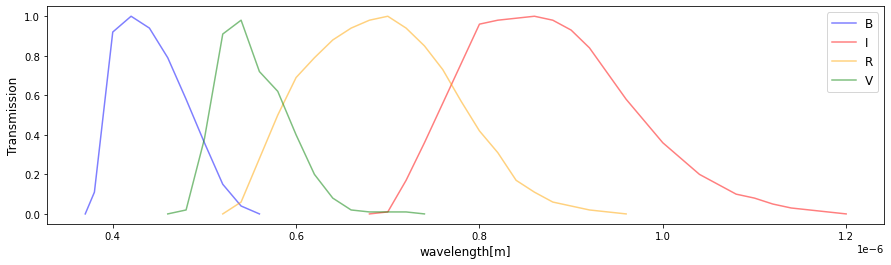

In [3]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'B,I,R,V'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange,g,black'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

# rotaion

In [4]:
def lc_spot(params, radius, dist, spot_size, spot_temp, ngrid, nrho, inc, theta, psi, phase_width, filter_name):
    '''
    radius       [R_sun]: stellar radius 
    dist             [m]: distance
    spot_size   [R_star]: spot size in stellar radius
    ngrid               : mesh grid
    nrho                : the number of points along the circumference of the spot
    inc         [radian]: inclination
    theta       [radian]: longitude
    phi         [radian]: latitude
    phase_width [radian]: 
    filter_name         : 'V','B' etc..
    
    '''
    
    teff, uteff, logg, ulogg, feh, ufeh = params
    phi = math.pi/2 - inc
    phase = np.arange(0, 2*np.pi, phase_width)
    spot0_pos_ang = np.linspace(0, 2*np.pi, nrho)
    spot_origin = np.array([[1],[0],[0]])
    
    R = _Ry(psi) * _Rz(theta) * _Ry(phi)
    ldcs = _ldc(params, filter_name)
    I_mean = _band_intensity(teff,filt[filter_name])
    spot_ratio = _band_intensity(spot_temp, filt[filter_name])/I_mean
    #print('mean intensity:', I_mean)
    #print('ratio =', spot_ratio)
    
    coord_all = []
    coord_min = []
    coord_max = []
    for i in range(len(phase)):

        ys        = [[] for _ in range(nrho)] 
        zs        = [[] for _ in range(nrho)] 
        spot0   = [[] for _ in range(nrho)] #matrix
        coord0 =  [[] for _ in range(nrho)] #matrix after rotation

        for j in range(nrho):
            x0 = np.sqrt(1 - spot_size**2)
            zs[j] = spot_size * np.sin(spot0_pos_ang[j])
            ys[j] = spot_size * np.cos(spot0_pos_ang[j])

            spot0[j] = np.array([[x0],[ys[j]],[zs[j]]])
            coord0[j] = (_Ru(inc, phase[i]) * (R * spot0[j]))

        coord_all.append(coord0)
        coord_max.append(np.amax(coord_all[i], axis=0))
        coord_min.append(np.amin(coord_all[i], axis=0))
        
        
    Zs = [[] for _ in range(len(phase))] 
    m = Mesh2D([-1,1], [-1, 1], ngrid)
    for i in range(len(phase)):
        Zs[i] = _g_ratio(m.X, m.Y, ldcs, I_mean, coord_min[i][0],coord_max[i][0],coord_min[i][1],coord_max[i][1], coord_min[i][2], coord_max[i][2], spot_ratio)


    sum_intensity_x = [[] for _ in range(len(phase))] 
    sum_intensity   = [[] for _ in range(len(phase))] 
    test_flux   = [[] for _ in range(len(phase))] 
    spot_mag        = [[] for _ in range(len(phase))] 
    
    test_flux_new  = [[] for _ in range(len(phase))] 
    for i in range(len(Zs)):
        for j in range(len(Zs[i])):
            sum_intensity_x[i].append(math.fsum(Zs[i][j]))
        sum_intensity = math.fsum(sum_intensity_x[i])
        r_d = radius * R_sun/dist
        test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(r_d)) + 1)
        #arcsin's 3rd order Maclaurin expansion
        arcsin = r_d + 1/6*r_d**3 + 3/40*r_d**5 + 5/112*r_d**7
        test_flux_new = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-(1 - 1/2 *(2*arcsin)**2 + 1/24*(2*arcsin)**4 - 1/720*(2*arcsin)**6) + 1)
        spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6)
        
    return coord_all, phase, spot_mag

In [5]:
params = [5700, 90, 4.470, 0.054, -0.01, 0.14]
coo_all_sun = [[] for _ in range(len(bands))] 
pha_sun = [[] for _ in range(len(bands))] 
mags_sun = [[] for _ in range(len(bands))] 
for i,b in zip(range(len(bands)),bands):
    coo_all_sun[i], pha_sun[i], mags_sun[i] = lc_spot(params, 1, au, 0.1, 3000, 100, 20, np.pi/2-np.pi/6, np.pi/6, 0, np.pi/12, b)


<ipython-input-2-f92dc549424b>:60: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


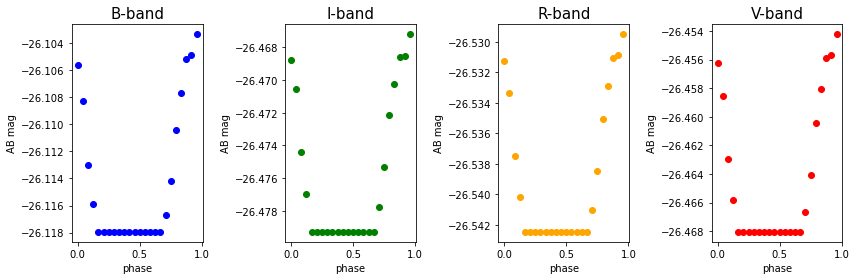

In [6]:
colors = ['b','g','orange','r']

#since there are 3 plots, use subplot
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(12,4), sharex=True)

n=0

for i,b,co in zip(range(4),bands,colors):
    
    ax[n].scatter(pha_sun[i]/(2*np.pi), mags_sun[i], color=co)
    
    #add plot labels
    ax[n].set_title(str(b) + '-band', fontsize=15)
    ax[n].set_xlabel('phase')
    ax[n].set_ylabel('AB mag')
    #ax[n].legend(loc='lower left')
    #increase the axis counter
    n=n+1
    
#make better spacing
fig.tight_layout()

In [7]:
params_dm = [5700, 90, 4.470, 0.054, -0.01, 0.14]
coo_all_dm = [[] for _ in range(len(bands))] 
pha_dm = [[] for _ in range(len(bands))] 
mags_dm = [[] for _ in range(len(bands))] 
for i,b in zip(range(len(bands)),bands):
    coo_all_dm[i], pha_dm[i], mags_dm[i] = lc_spot(params_dm, 1, 145*pc, 0.1, 3000, 100, 20, np.pi/2, 0, 0, np.pi/12, b)

<ipython-input-2-f92dc549424b>:60: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


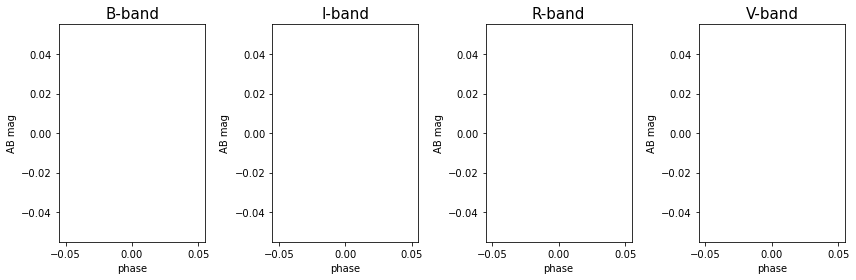

In [8]:
colors = ['b','g','orange','r']

#since there are 3 plots, use subplot
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(12,4), sharex=True)

n=0

for i,b,co in zip(range(4),bands,colors):
    
    ax[n].scatter(pha_dm[i]/(2*np.pi), mags_dm[i], color=co)
    
    #add plot labels
    ax[n].set_title(str(b) + '-band', fontsize=15)
    ax[n].set_xlabel('phase')
    ax[n].set_ylabel('AB mag')
    #ax[n].legend(loc='lower left')
    #increase the axis counter
    n=n+1
    
#make better spacing
fig.tight_layout()